## i. BUSINESS JOB DESCRIPTION

*   Our client is an e-commerce company (_All in one Place_), a multibrand outlet. It profits comes from reseling large quantities of various products by offering low tag prices.

*   After collecting data from their clients database during the period of 1 year, the company's marketing team is analyzing wheter it would be profitable or not to separate it into distinct groups, in order to distinguish those who represent a larger ammount of the company's earnings.

*   The intended group of interest obtained from this clustering analysis will then be called 'Insiders', and will be targeted as eligible clients to win special fidelity programs opportunities.

## ii. THE CHALLENGE

*   I was hired as a Data Scientist consultant, in order to build a model capable of performing such clustering with great accuracy.

*   With the solution, the marketing team can acordingly plan how to target groups of clients in order to optimize profits.

*   In order to understand client's behaviour, we have a database containing information about sales transactions, specifying the products that were bought, their description, quantity, unit price as well as general information about client's physical location (Customer ID, country).

## iii. BUSINESS QUESTIONS

*   It is expected a report as the result of the clsutering analysis, which answers the following questions:

    1.  Which clients are eligible  to take part on the 'Insiders' group ?
    
    2.  How many clients will be selected?

    3.  What are the main features that impacts more the clustering analysis from said clients?

    4.  What is the 'Insiders' group percentage upon the company's total earnings?
    
    5.  What is the expected profit from the 'Insiders' group for the next months?

    6.  What are the main conditions that make one eligible for being on 'Insiders'?

    7.  What are the conditions for one to be excluded from 'Insiders'?

    8.  What guarantees that 'Insiders' group grants more profits to the company compared to the rest of the database?

    9.  Which actions the marketing team can partake to increase profits?


# 0.0 IMPORTS, FUNCTIONS AND DATABASE LOAD

## 0.1 Imports

In [1]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import umap.umap_   as umap
import psycopg2
import s3fs
import pickle
import ipywidgets
import inflection
import warnings
import os

from matplotlib         import pyplot as plt
from collections        import Counter
from ydata_profiling    import ProfileReport
from pandasql           import sqldf

from sklearn.preprocessing      import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition      import PCA
from sklearn.manifold           import TSNE
from sklearn.mixture            import GaussianMixture
from sklearn.ensemble           import RandomForestRegressor, ExtraTreesClassifier
from sklearn.cluster            import KMeans, DBSCAN
from sklearn.neighbors          import NearestNeighbors
from sklearn.metrics            import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy    import linkage, dendrogram, fcluster
from scipy.spatial.distance     import pdist, squareform

from plotly                     import express as px

from sqlalchemy import create_engine, text

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Helper Functions

In [2]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Database load

In [4]:
path_local = '/home/valquiriaam/repos/PA005/'
path_s3 = 's3://insiders-dataset-pa005/'

df_raw = pd.read_csv(path_s3+'ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [5]:

df1 = df_raw.copy()
df1 = df1.drop(columns=['Unnamed: 8'])

In [6]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 541909
Number of Columns: 8


# 1.0 DATA DESCRIPTION

### 1.3.1 General Description

In [7]:
#df1_profile = ProfileReport(df1, title='Profile Report')
#df1_profile

In [8]:
#df1_profile.to_file('raw_dataset_profile.html')

### 1.3.2 Data Typification

*   InvoiceNo: Unique Transaction ID

*   StockCode: Item's ID code

*   Description: Item's name

*   Quantity: Quantity of product bought

*   InvoiceDate: Transaction's occurance date

*   UnitPrice:  Product's price per unit

*   CustomerID: Customer's ID code

*   Country: Customer's Country

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [11]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### 1.3.3 Missing Data Treatment

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [13]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_complete = df1.loc[~df1['customer_id'].isna(), :]

df_complete.loc[df_complete['invoice_no'].isin(df_missing['invoice_no']), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


*   No Matches for invoice_no entries for rows with customer_id = NaN.

In [14]:
df_complete['customer_id'].max()

18287.0

*   Customer_id NaN values will be filled with values 19000 onwards, in order to maintain data information on our model.

In [15]:
#Customer_id labeling
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1 )

#merge into main dataframe
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

#coalesce - combine first
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [16]:
df1['customer_id'] = df1['customer_id'].astype(int64)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [17]:
df1.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   country       541909 non-null  object        
 7   customer_id   541909 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 33.1+ MB


In [18]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 541909
Number of Columns: 8


### 1.3.4 Numerical and Categorical Data Description

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [20]:
#invoice number -> Distinct Categorical entries
invoiceno_strings = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),'invoice_no'])
negative_quantities = len(num_attributes[num_attributes['quantity'] < 0])
print(f'Count of Distinct invoice_no strings: {invoiceno_strings} \n' +
      f'Count of entries with negative quantities: {negative_quantities}')

Count of Distinct invoice_no strings: 9291 
Count of entries with negative quantities: 10624


In [21]:
df1.loc[(df1['customer_id'] > 19000) & (df1['quantity']< 0) &
        (df1['invoice_no'].apply(lambda x: bool(re.search('^[0-9]+', x)))), :].shape[0]

1336

*   The Last output shows that we now have numerical 'invoice_no' rows containing negative quantities.

In [22]:
#After customer_id fill na
new_invoice_str = df1.loc[(df1['customer_id'] > 19000) &
                          (df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))), :].shape[0]
new_invoice_negative = df1.loc[(df1['customer_id'] > 19000) & (df1['quantity']< 0) &
                          (df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))), :].shape[0]

print(f'Total invoice_no string rows: {new_invoice_str} \n' +
      f'Total negative quantity rows: {new_invoice_negative}')

Total invoice_no string rows: 386 
Total negative quantity rows: 383


In [23]:
df1.loc[(df1['customer_id'] > 19000) & (df1['quantity']>0) &
        (df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


*   After customer_id fill na, rows with invoice_no following the pattern Cxxxxxx still have negative quantities, thus reaffirming its 'retuned/canceled' entries status.
*   The few remaining entries fors rows with invoice_no containing string values will be removed, as the last output shows that they do not represent any item purchase.

In [24]:
#stock_code -> List of Selected Categorical Entries to further examine
at_least_one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
print(f'Total Number of stock codes containing letters: {at_least_one_string}')

cat_stock = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
print(f'Total Number of string stock_codes : {len(cat_stock)}; Unique Stock Codes:{cat_stock}')

Total Number of stock codes containing letters: 54873
Total Number of string stock_codes : 12; Unique Stock Codes:['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


In [25]:
df_cat = df1[df1['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE',
                                     'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B',
                                     'CRUK'])]
df_cat.shape

(2759, 8)

In [26]:
#country
cat_attributes['country'].unique()



array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

Upon Analyzing Pandas profiling:

## Numerical Data Premisses

*   Rows with 'unit_price' listed as a negative value (-11062,06) will be deleted. (Not a sale entry, it is descripted as a bad debt adjust)
*   Rows with 'unit_price' listed as 0 (values between 0.0 and 0.01) will be deleted.
*   Rows with quantity listed as negative values are always corrective entries from its previous ones (returned, cancelled entries), and its invoice_number always follows the pattern Cxxxxxx.

#Categorical Data Premises

*   Rows with 'invoice_no' containing any letter (mainly folowing the pattern Cxxxxxx), will be separated as 'return dataset'; This will contain only data from cancelled/returned entries.
*   Rows with Stock Codes that only contains letters (['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']) will be deleted given that they do not represent a selling transaction.
*   Rows with country listed as ([['Unspecified', 'European Community']) will be removed.


# 2.0 DATA FILTERING

In [27]:
df2 = df1.copy()

In [28]:
#customer_id outlier removal
df2 = df2.loc[~df2['customer_id'].isin([16446, 12346])]

# unit_price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock_code != ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE',
                                       'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B',
                                       'CRUK'])]

#description
df2 = df2.drop(columns='description', axis=1)

# country != ['Unspecified', 'European Community']
df2 = df2.loc[~df2['country'].isin(['Unspecified', 'European Community'])]

#Quantity: Negative products means product returns; sale cancelled
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0 FEATURE ENGINEERING





In [29]:
df3 = df2.copy()

In [30]:
#data_reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
                   'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

In [31]:
## Posíveis Idéias de Features:
# Moving Avg -> 7d, 14d, 31d
# Quantidade de Compras por mês -> Antes do dia 15; depois do dia 15

## 3.1 Gross Revenue

In [32]:
#Gross Revenue
df2_purchases['revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']
df_monetary = df2_purchases[['customer_id', 'revenue']].groupby(['customer_id']).sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

## 3.2 Recency

*   Reference point adopted as the most recent date on dataset ('2017-12-07').

In [33]:
#Recency -> Reference point adopted as the newest data on dataset ('2017-12-07')
df2_purchases['recency'] = df3['invoice_date'].max() - df2_purchases['invoice_date']
df2_purchases['recency'] = df2_purchases['recency'].dt.days
df_recency = df2_purchases[['customer_id', 'recency']].groupby('customer_id').min('recency').reset_index()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

## 3.3 Total Products

In [34]:
#Total Products Bought per customer
df_products = df2_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_products = df_products.rename(columns={'quantity': 'total_products'})
df_ref = pd.merge(df_ref, df_products, on='customer_id', how='left')

## 3.4 Distinct Products per Customer


In [35]:
#Total number of distinct products (stock_code) per customer
df_stock = df2_purchases[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index()
df_stock = df_stock.rename(columns={'stock_code': 'distinct_stock_code'})
df_ref = pd.merge(df_ref, df_stock, on='customer_id', how='left')

## 3.5 Total Purchases

In [36]:
#Total number of purchases (invoice_no) per customer
df_purchases = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_purchases = df_purchases.rename(columns={'invoice_no': 'total_purchases'})
df_ref = pd.merge(df_ref, df_purchases, on='customer_id', how='left')

## 3.6 Average Basket Size

In [37]:
#Basket Size: Average number of total products(quantity) per purchase(invoice_no)
df_basket = df2_purchases[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).sum().reset_index()
df_basket = df_basket[['customer_id', 'quantity']].groupby('customer_id').mean().reset_index()
df_basket = df_basket.rename(columns={'quantity': 'basket_size'})
df_ref = pd.merge(df_ref, df_basket, on='customer_id', how='left')

## 3.7 Average Unique Basket Size

In [38]:
# Unique Basket Size: Average number of total distinct products (stock_code) per purchase(invoice_no)
df_unique_basket = df2_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby(['customer_id', 'invoice_no']).count().reset_index()
df_unique_basket = df_unique_basket[['customer_id', 'stock_code']].groupby('customer_id').mean().reset_index()
df_unique_basket = df_unique_basket.rename(columns={'stock_code': 'unique_basket_size'})
df_ref = pd.merge(df_ref, df_unique_basket, on='customer_id', how='left')

## 3.8 Average Ticket

In [39]:
#Avg Ticket per client
df_ticket = df2_purchases[['customer_id', 'revenue']].groupby(['customer_id']).mean().reset_index()
df_ticket = df_ticket.rename(columns={'revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on='customer_id', how='left')

## 3.9 Frequency

In [40]:
df_freq = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                       .groupby('customer_id')
                                                                       .agg( max_ = ( 'invoice_date', 'max'),
                                                                             min_ = ( 'invoice_date', 'min'),
                                                                             days_ = ( 'invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                             buy_ = ('invoice_no', 'count'))).reset_index()

#Frequency
df_freq['frequency'] = df_freq[['buy_', 'days_']].apply( lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

#Merge
df_ref = pd.merge(df_ref, df_freq[['customer_id', 'frequency']], on='customer_id', how='left')

## 3.10 Total Returned Products

In [41]:
df_returned = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'returned'})
df_returned['returned'] = df_returned['returned'] * (-1)

df_ref = pd.merge(df_ref, df_returned, on='customer_id', how='left')
df_ref.loc[df_ref['returned'].isna(), 'returned'] = 0

In [42]:
df_ref.isna().sum()

customer_id             0
revenue                91
recency                91
total_products         91
distinct_stock_code    91
total_purchases        91
basket_size            91
unique_basket_size     91
avg_ticket             91
frequency              91
returned                0
dtype: int64

In [43]:
df_ref.head()

,customer_id,revenue,recency,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
0,17850,5391.21,372.0,1733.0,297.0,34.0,50.970588,8.735294,18.152222,17.000000,40.0
1,13047,3232.59,56.0,1390.0,171.0,9.0,154.444444,19.000000,18.904035,0.028302,35.0
2,12583,6705.38,2.0,5028.0,232.0,15.0,335.200000,15.466667,28.902500,0.040323,50.0
3,13748,948.25,95.0,439.0,28.0,5.0,87.800000,5.600000,33.866071,0.017921,0.0
4,15100,876.00,333.0,80.0,3.0,3.0,26.666667,1.000000,292.000000,0.073171,22.0


#   4.0 EDA (EXPLORATORY DATA ANALYSIS)

*   The goal here is to look after features that introduces great variability to our model, in order to obtain **condensed and distant** clusters.

*   Central tendency Metrics : Mean, Median
    *   Look after values that are too far from the central tendency (Outliers)
*   Dispersion Metrics: Min & Max values (range), Standard Deviation, Variance (std / Nº of examples), Variance Coef (CV)(std/mean)
    *   Generally, features with high variance are wanted in our model.
    *   Wide range features tend to offer more variability to our model.
*   Variable Distribution




In [44]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id            0
revenue                0
recency                0
total_products         0
distinct_stock_code    0
total_purchases        0
basket_size            0
unique_basket_size     0
avg_ticket             0
frequency              0
returned               0
dtype: int64

# 5.0 DATA PREPARATION

In [45]:
df5 = df4.copy()

In [46]:
df5 = df5.drop( columns = ['customer_id'], axis=1)

In [47]:
df5_aux = df5.copy()

## 5.1 Numerical Values (Reescaling, Standardization)

In [48]:
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

fs = s3fs.S3FileSystem(anon=False, key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY )

In [49]:
##Standard Scaler
ss = StandardScaler()
rs = RobustScaler()
mms = MinMaxScaler()


#revenue_scaler            = pickle.load(open(path_local + 'src/features/revenue_scaler.pkl', 'rb'))
revenue_scaler             = pickle.load(fs.open(path_s3 + 'revenue_scaler.pkl', mode='rb'))
df5['revenue']             = revenue_scaler.transform(df5[['revenue']])

#recency_scaler            = pickle.load(open(path_local + 'src/features/recency_scaler.pkl', 'rb'))
recency_scaler             = pickle.load(fs.open(path_s3 + 'recency_scaler.pkl', mode='rb'))
df5['recency']             = recency_scaler.transform(df5[['recency']])

#total_products_scaler     = pickle.load(open(path_local + 'src/features/total_products_scaler.pkl', 'rb'))
total_products_scaler      = pickle.load(fs.open(path_s3 + 'total_products_scaler.pkl', mode='rb'))
df5['total_products']      = total_products_scaler.transform(df5[['total_products']])

#distinct_stock_code_scaler= pickle.load(open(path_local + 'src/features/distinct_stock_code_scaler.pkl', 'rb'))
distinct_stock_code_scaler = pickle.load(fs.open(path_s3 + 'distinct_stock_code_scaler.pkl', mode='rb'))
df5['distinct_stock_code'] = distinct_stock_code_scaler.transform(df5[['distinct_stock_code']])

#total_purchases_scaler    = pickle.load(open(path_local + 'src/features/total_purchases_scaler.pkl', 'rb'))
total_purchases_scaler     = pickle.load(fs.open(path_s3 + 'total_purchases_scaler.pkl', mode='rb'))
df5['total_purchases']     = total_purchases_scaler.transform(df5[['total_purchases']])

#basket_size_scaler        = pickle.load(open(path_local + 'src/features/basket_size_scaler.pkl', 'rb'))
basket_size_scaler         = pickle.load(fs.open(path_s3 + 'basket_size_scaler.pkl', mode='rb'))
df5['basket_size']         = basket_size_scaler.transform(df5[['basket_size']])

#unique_basket_size_scaler = pickle.load(open(path_local + 'src/features/unique_basket_size_scaler.pkl', 'rb'))
unique_basket_size_scaler  = pickle.load(fs.open(path_s3 + 'unique_basket_size_scaler.pkl', mode='rb'))
df5['unique_basket_size']  = unique_basket_size_scaler.transform(df5[['unique_basket_size']])

#avg_ticket_scaler         = pickle.load(open(path_local + 'src/features/avg_ticket_scaler.pkl', 'rb'))
avg_ticket_scaler          = pickle.load(fs.open(path_s3 + 'avg_ticket_scaler.pkl', mode='rb'))
df5['avg_ticket']          = avg_ticket_scaler.transform(df5[['avg_ticket']])

#frequency_scaler          = pickle.load(open(path_local + 'src/features/frequency_scaler.pkl', 'rb'))
frequency_scaler           = pickle.load(fs.open(path_s3 + 'frequency_scaler.pkl', mode='rb'))
df5['frequency']           = frequency_scaler.transform(df5[['frequency']])

#returned_scaler           = pickle.load(open(path_local + 'src/features/returned_scaler.pkl', 'rb'))
returned_scaler            = pickle.load(fs.open(path_s3 + 'returned_scaler.pkl', mode='rb'))
df5['returned']            = returned_scaler.transform(df5[['returned']])


X = df5.copy()

### 5.3.4 Tree-based Embedding

In [50]:
columns = [ 'total_purchases', 'total_products', 'frequency' ,
            'unique_basket_size', 'avg_ticket']

In [51]:
df_tree = X.drop(columns=columns, axis=1)

In [52]:
X = df_tree.drop(columns=['revenue'], axis = 1)
y = df_tree[['revenue']]

In [53]:
##Model Definition
#rf_model = RandomForestRegressor(n_estimators=100, random_state = 42)
#
##Model Training
#rf_model.fit(X, y)
#pickle.dump(rf_model, open('../models/rf_model.pkl', 'wb'))

#Load Model
#rf_model = pickle.load(open(path_local + 'src/models/rf_model.pkl', 'rb'))
rf_model = pickle.load(fs.open(path_s3 + 'rf_model.pkl', mode='rb'))

In [54]:
#Tree Leaves
df_leaf = pd.DataFrame(rf_model.apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,6643,6727,6869,6592,6697,6844,6822,6959,6776,7189,6793,6556,6958,6822,6829,6616,6869,6551,7021,6997,6652,6741,7043,7064,6954,6770,6436,6484,6675,6789,6971,7170,7047,6774,6994,6612,6476,7047,6477,7089,6505,6947,6523,6532,6956,6676,7051,6641,7065,6976,7189,7062,6475,6562,7033,6616,6612,6646,6797,6869,6937,6996,6952,7011,7052,6760,6704,6680,6983,7031,6595,6982,6956,6502,6471,6751,6889,6680,7153,6838,7056,6831,6624,6325,6580,6550,6942,6366,6955,6511,6967,6765,6805,6693,6591,6751,7032,6785,6839,6629
1,6467,6682,6437,6052,6587,6692,6263,6103,6518,6476,6710,6430,6311,6742,6161,6402,6425,5756,6504,6182,6642,6496,5930,6366,6049,6746,6452,6476,6630,6588,5915,6528,5959,6739,6960,6616,6566,5875,6393,6101,6495,6856,6567,6469,6157,6660,7018,6543,6577,6919,7145,6595,6472,6493,6429,6522,6519,6605,6696,6232,6001,6928,6482,6446,6614,6360,6620,6540,6927,6435,6544,6030,6056,6429,6466,6697,6360,6399,6064,6121,5933,6391,6503,6544,6388,6541,6358,6386,5736,6457,6429,6219,6518,6222,6550,6332,6949,6506,6508,6637
2,6660,6858,6499,6666,6723,6891,6354,7025,7078,7116,6813,6523,6435,6783,6857,6602,6895,6974,6549,7010,6775,6733,7059,6487,7008,6769,6521,6583,5432,6817,6886,6609,7036,6809,7039,6952,6672,7075,6501,7018,5078,6926,6747,6770,6873,6616,7058,6579,6979,6877,7100,6565,6561,6570,6480,7087,6623,6692,6780,6319,7009,6971,6525,6441,6673,6471,6723,6655,7002,6489,6984,7015,6992,6731,6548,6636,6442,6686,7098,6996,7054,6459,6617,6643,6493,6977,6489,6624,6904,6558,6546,6429,7050,6350,6520,6790,7010,6771,6477,7121
3,2853,3300,2745,2732,2225,2861,2273,3002,2923,2589,2591,3080,3121,1652,2767,2756,2656,2909,2959,2449,2588,2797,3023,1645,1647,2630,3067,3115,2620,2906,3088,3006,2948,2194,2418,2819,1724,3005,2945,1710,2762,2718,2402,2447,2731,2579,2768,3153,1655,2895,2834,3040,2896,2652,2809,1613,2757,2723,1698,1765,2777,2538,2457,2782,1503,2425,2963,2600,2855,2888,2291,3086,2756,2553,2816,2821,2900,2809,2426,3193,2940,1811,2880,2016,3077,2498,2972,2718,2901,1655,2787,3047,1597,2771,2990,3016,1785,1977,2824,2408
4,1718,973,765,862,861,656,1032,2492,1551,1002,1343,1463,750,881,879,944,885,717,2522,673,1308,792,949,1252,1036,1347,1527,1300,843,1517,971,1513,733,791,939,1300,910,955,857,1118,988,1023,795,1150,1348,2065,994,924,1148,712,905,1486,882,1225,935,1749,1568,1131,1067,996,1286,910,1236,949,927,949,1142,4414,1662,995,1279,869,965,855,927,1168,805,1224,637,946,915,1474,1337,775,4393,968,1340,4440,4252,1199,706,1357,910,943,818,1033,1007,1243,988,931


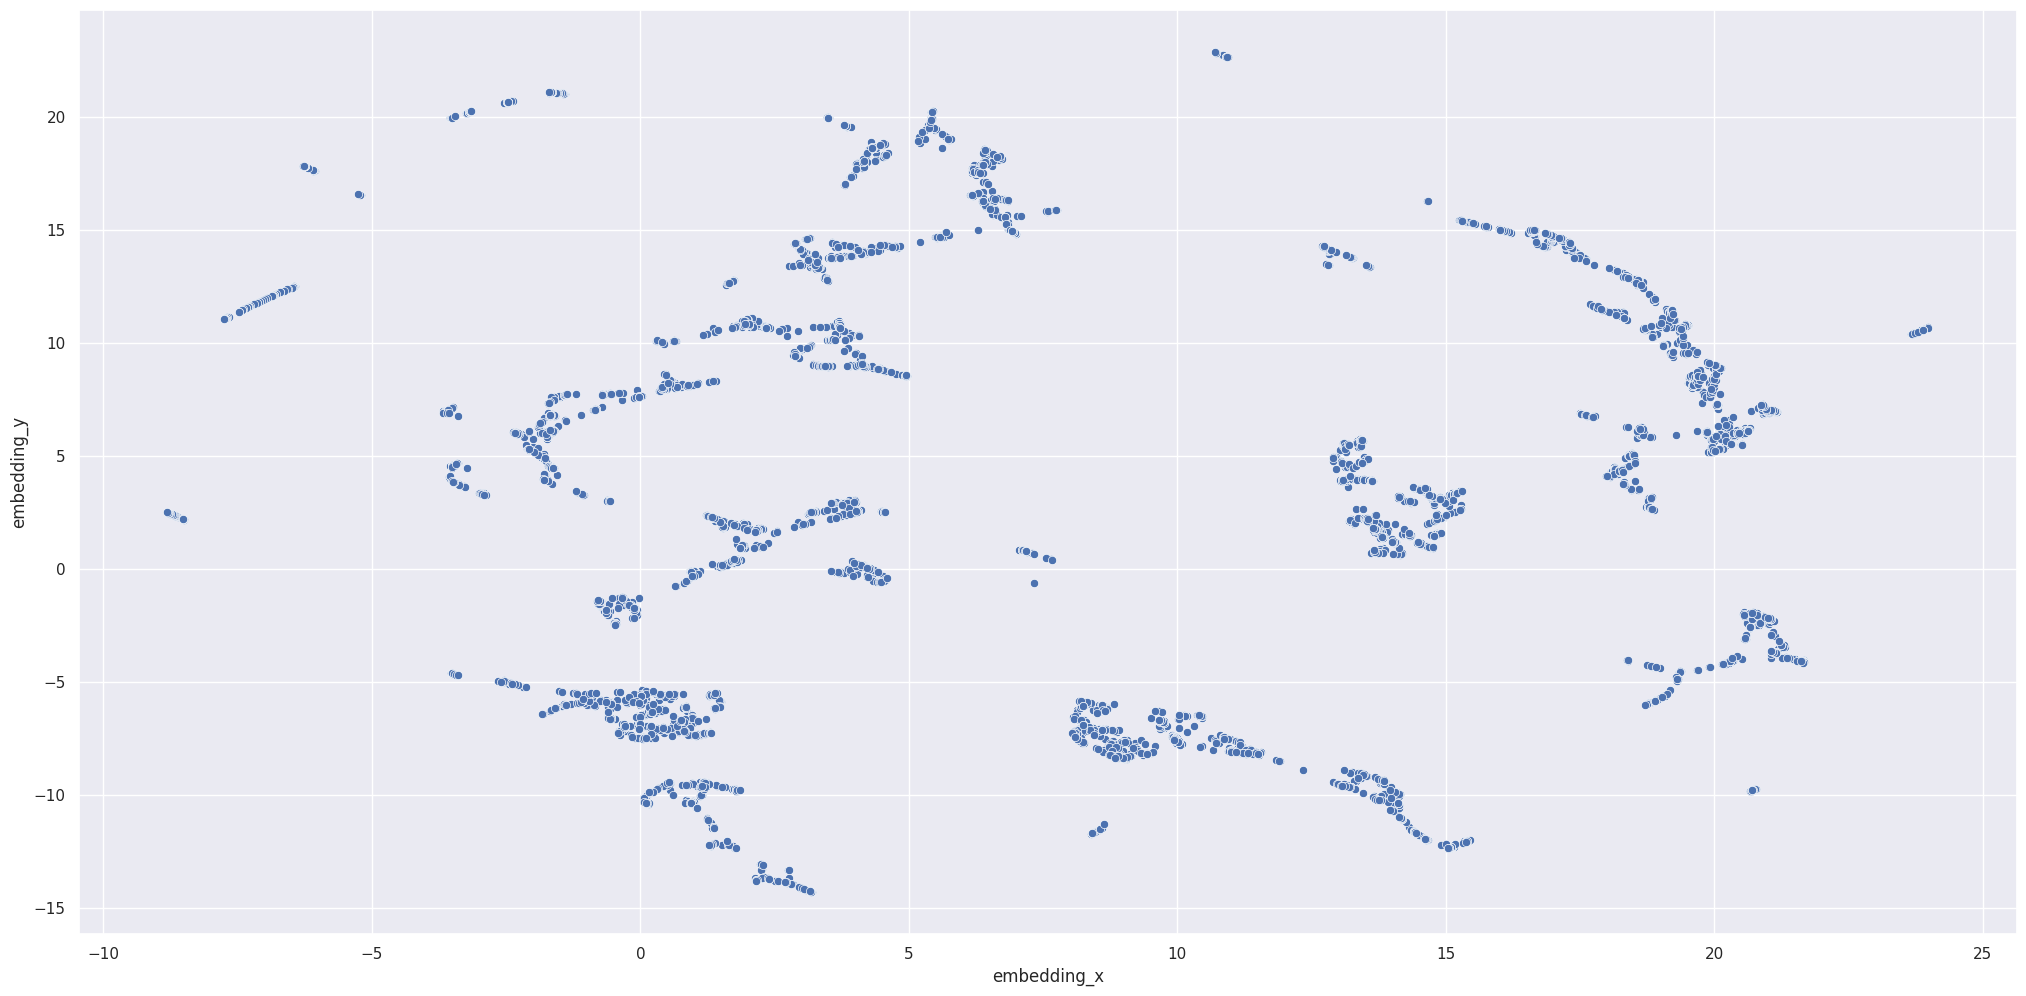

In [55]:
##@title { vertical-output: true}
#reducer = umap.UMAP( random_state=42 )
#pickle.dump(reducer, open('../features/umap_reducer.pkl', 'wb'))

#reducer = pickle.load(open(path_local + 'src/features/umap_reducer.pkl', 'rb'))
reducer = pickle.load(fs.open(path_s3 + 'umap_reducer.pkl', mode='rb'))
embedding = reducer.fit_transform( df_leaf )

#embedding
#df_pca['embedding_x'] = embedding[:, 0]
#df_pca['embedding_y'] = embedding[:, 1]

df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#Plot
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

#   6.0 FEATURE SELECTION

In [55]:
df6 = df_tree.copy()

In [56]:
df6.head()

,embedding_x,embedding_y
0,4.582253,18.303787
1,4.189081,13.990575
2,4.242920,18.485781
3,13.035638,-9.498940
4,20.575422,6.260707


# 7.0 HYPERPARAMETER FINE-TUNNING





In [57]:
df7 = df6.copy()

In [58]:
X = df7.copy()

In [59]:
X.head()

,embedding_x,embedding_y
0,4.582253,18.303787
1,4.189081,13.990575
2,4.242920,18.485781
3,13.035638,-9.498940
4,20.575422,6.260707


# 8.0 MODEL TRAINING

In [60]:
k = 10

#Model definition
kmeans_model = KMeans(n_clusters=k, n_init=300, 
                      random_state=42)

#Model Training
kmeans_model.fit(X)

#Labeling
labels = kmeans_model.labels_

In [61]:
#WSS (Within-Cluster Sum of Square)
print(f'WSS value: {kmeans_model.inertia_}')

#SS (Silhouette Score)
print(f'Silhouette Score: {silhouette_score(X, labels)}')

WSS value: 51268.6484375
Silhouette Score: 0.5422177910804749


# 9.0 CLUSTER ANALYSIS

In [62]:
df9 = X.copy()

## 9.1  Visualization Inspection

In [63]:
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,4.582253,18.303787,3
1,4.189081,13.990575,7
2,4.242920,18.485781,3
3,13.035638,-9.498940,4
4,20.575422,6.260707,1


In [64]:
df_viz = df9.copy()

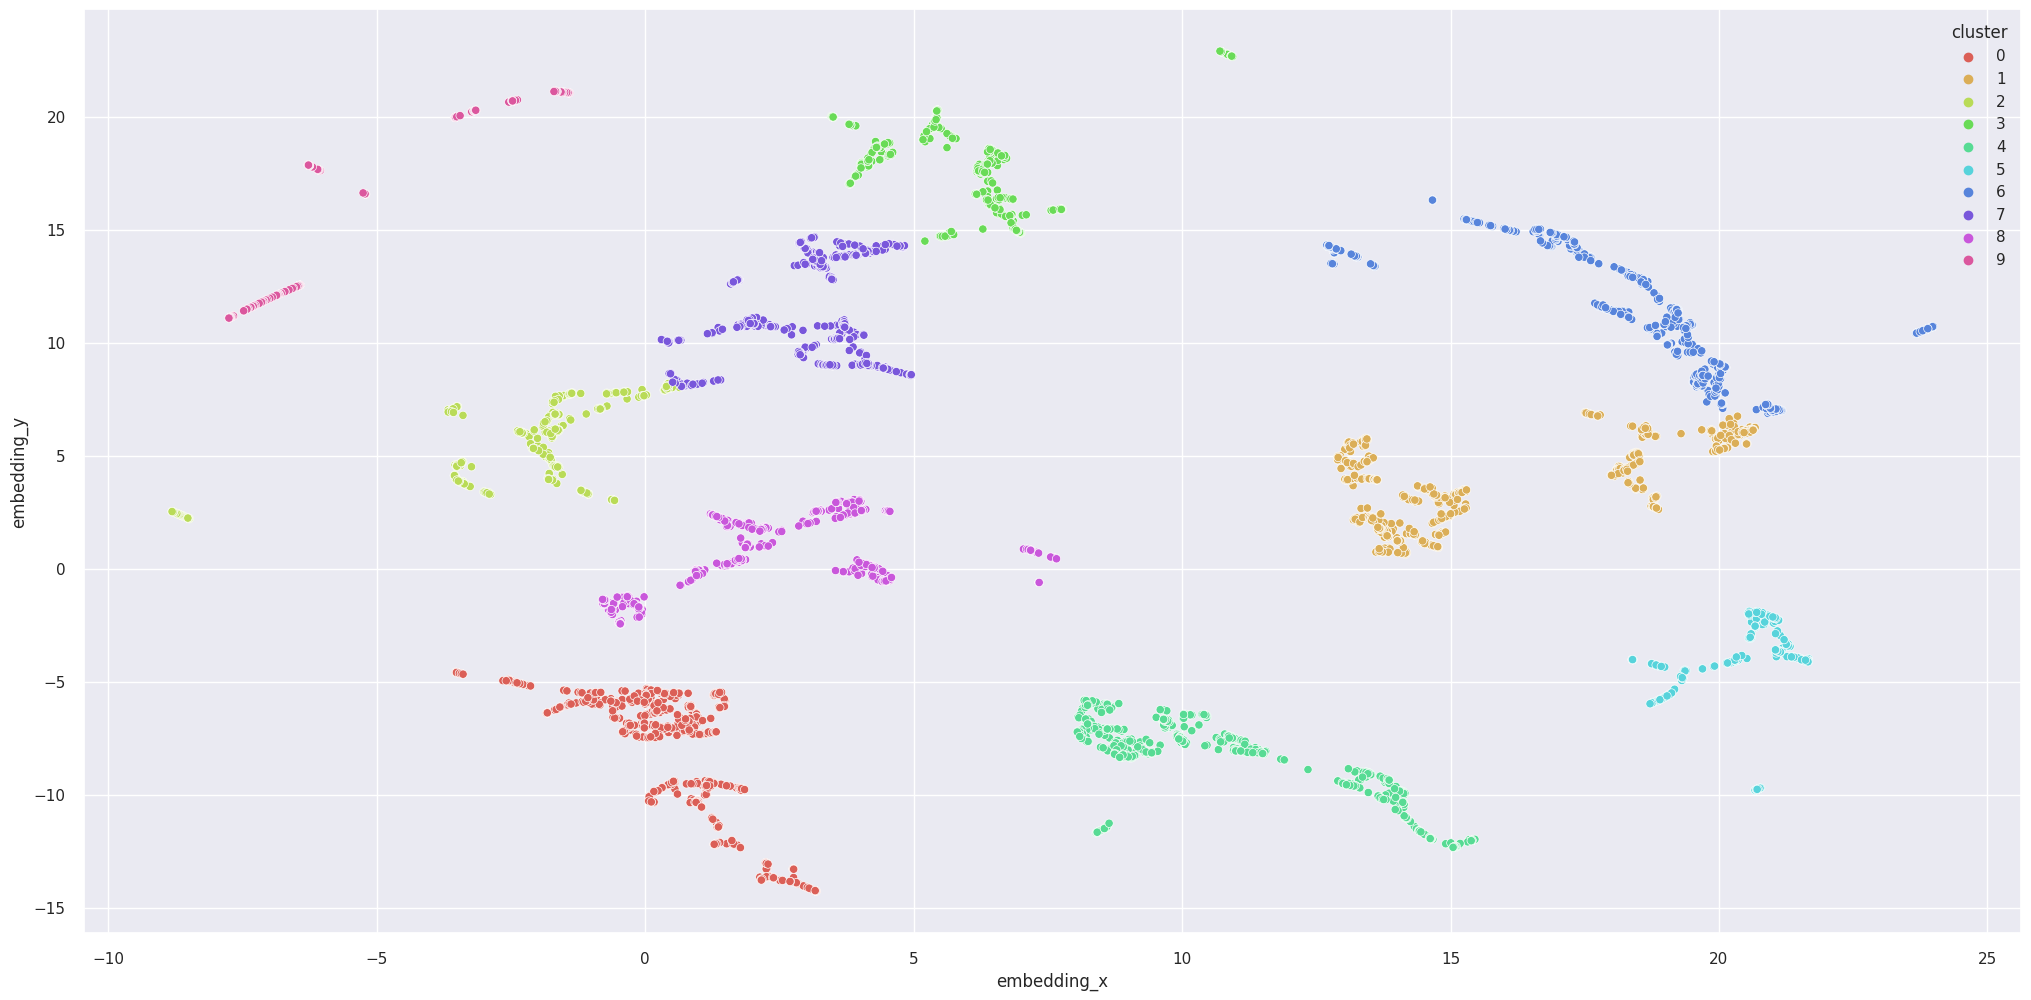

In [65]:
sns.scatterplot(x= 'embedding_x', y= 'embedding_y',
                hue='cluster',
                palette= sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## 9.2 Cluster Profile

In [66]:
df9_embed = df4.copy().drop(columns=columns, axis=1)
df9_embed['cluster'] = labels
df9_embed.head()

,customer_id,revenue,recency,distinct_stock_code,basket_size,returned,cluster
0,17850,5391.21,372.0,297.0,50.970588,40.0,3
1,13047,3232.59,56.0,171.0,154.444444,35.0,7
2,12583,6705.38,2.0,232.0,335.200000,50.0,3
3,13748,948.25,95.0,28.0,87.800000,0.0,4
4,15100,876.00,333.0,3.0,26.666667,22.0,1


In [67]:
#Number of Customers
df_customer = df9_embed[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_customer = df_customer.rename(columns={'customer_id': 'total_customers'})
df_customer['perc_customers'] = 100*(df_customer['total_customers']/df_customer['total_customers'].sum())

#Avg Revenue
df_revenue = df9_embed[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_revenue = df_revenue.rename(columns={'revenue': 'avg_revenue'})

#Avg Recency
df_recency = df9_embed[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_recency = df_recency.rename(columns={'recency': 'avg_recency'})

#Avg Distinct Products
df_total_products = df9_embed[['cluster', 'distinct_stock_code']].groupby('cluster').mean().reset_index()
df_total_products = df_total_products.rename(columns={'distinct_stock_code': 'avg_total_products'})

#Avg Basket Size
df_basket_size = df9_embed[['cluster', 'basket_size']].groupby('cluster').mean().reset_index()
df_basket_size = df_basket_size.rename(columns={'basket_size': 'avg_basket_size'})

#Avg Returned Products
df_returned = df9_embed[['cluster', 'returned']].groupby('cluster').mean().reset_index()
df_returned = df_returned.rename(columns={'returned': 'avg_returned_products'})


df_profile = pd.merge(df_customer, df_revenue, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_recency, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_total_products, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_basket_size, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_returned, how='left', on='cluster')

df_profile.sort_values('avg_revenue', ascending=False)

,cluster,total_customers,perc_customers,avg_revenue,avg_recency,avg_total_products,avg_basket_size,avg_returned_products
3,3,507,8.904110,9054.376982,75.453649,441.883629,680.612320,137.844181
7,7,605,10.625220,2583.960264,64.426446,174.876033,337.971965,16.847934
8,8,600,10.537408,1724.837317,85.935000,76.018333,397.209676,10.180000
2,2,450,7.903056,1372.473956,119.402222,134.400000,250.878185,7.613333
4,4,730,12.820513,1232.895562,109.917808,41.582192,177.524132,5.205479
0,0,763,13.400070,969.792674,106.783748,50.808650,232.561988,5.542595
5,5,332,5.830699,708.530633,137.111446,18.783133,249.462161,14.099398
1,1,816,14.330875,321.068958,146.665441,13.034314,121.680929,1.725490
6,6,718,12.609765,113.875320,173.440111,7.225627,27.490935,0.169916
9,9,173,3.038286,10.390173,182.716763,1.364162,1.705202,0.023121


## 9.3 Cluster Description

### 9.3.2 Data Space: Embedded Space - Tree Based Organization

*   O espaço de Embedding pode ser utilizado caso exista a necessidade da obtenção de um número maior de clusters, viabilizada por uma maior separação quando em comparação ao espaço de features.
*   O Trade off, no entanto, é que perde-se a explicabilidade da correlação entra as features aplicadas ao modelo.

### Análise dos Clusters:

### Cluster 03 (Insiders 01 -> Highest Revenue Cluster):

*   Total Number of Customers = 507 Clients (8.91% of the database)
*   Average Recency = 76 Days
*   Average number of distinct products bought  = 442 distinct products bought per client
*   Average Revenue = $9054.38 per client
*   **OBS**: Cluster containing the best metrics for most of the variable on the Insiders group (Highest revenue, product variety, basket size); however, look after reducing the 'returned_prodcuts' value.

### Cluster 07 (Insiders 02 ->  B Revenue Insiders) :

*   Total Number of Customers = 605 Clients (10.63% of the database)
*   Average Recency = 65 Days
*   Average Number of Distinct Products Bought  = 175 distinct products bought per client
*   Average Revenue = $2583.96 per client
*   **OBS**: Look after improving the revenue, by offering cross-sell with higher price tagged products.

### Cluster 08 (Insiders 03 -> Improve Product Variety Insiders):

*   Total Number of Customers = 600 Clients (10.54% of the database)
*   Average Recency = 86 Days
*   Average Number of Distinct Products Bought  = 77 distinct products bought per client
*   Average Revenue = $1724.84 per client
*   **OBS**: Look after improving the variety of products bought by clients on this cluster (Worst among the insiders, even while having 2nd best basket size).

### Cluster 02 (Insiders 04 -> Low Recency Insiders):

*   Total Number of Customers = 450 Clients (7.90% of the database)
*   Average Recency = 120 Days
*   Average Number of Distinct Products Bought  = 135 distinct products bought per client
*   Average Revenue = $1372.48 per Client
*   **OBS**: Look after improving the this cluster clients recency; get them to return at least once for every 90 days period (3 months).

### Cluster 04 (Viability Analysis for Insiders 01 -> Poor Variety Cluster):

*   Total Number of Customers = 730 Clients (12.82% of the database)
*   Average Recency = 110 Days
*   Average Number of Distinct Products Bought  = 42 distinct products bought per client
*   Average Revenue = $1232.90 per client
*   **OBS**: Worst Recency amongst the possible clusters selected to be part of Insiders.

### Cluster 00 (Viability Analysis for Insiders 02 -> Low Price Buyers):

*   Total Number of Customers = 763 Clients (13.40% of the database)
*   Average Recency = 107 Days
*   Average Number of Distinct Products Bought  = 51 distinct products bought per client
*   Average Revenue = $969.79 per client
*   **OBS**: Cluster with fairly best metrics than cluster 04 (Poor Variety Cluster), however, its average revenue is lower, indicating the need to make these clients to buy higher priced products.

### Cluster 05 (Not Insiders 01 -> Same product Buyers A):

*   Total Number of Customers = 332 Clients (5.84% of the database)
*   Average Recency = 138 Days
*   Average Number of Distinct Products Bought  = 19 distinct products bought per client
*   Average Revenue = $708.53 per client
*   **OBS**: Even tho the basket size is fairly great, this cluster a very poor variety of products bought.

### Cluster 01 (Not Insiders 02 -> Same Product Buyers B):

*   Total Number of Customers = 816 Clients (14.33% of the database)
*   Average Recency = 147 Days
*   Average Number of Distinct Products Bought  = 13 distinct products bought per client
*   Average Revenue = $321.07 per client
*   **OBS**:  Even tho the basket size is fairly great, this cluster a very poor variety of products bought.

### Cluster 06 (Not Insiders 03 -> Intermitent Buyers):

*   Total Number of Customers = 718 Clients (12.61% of the database)
*   Average Recency = 174 Days
*   Average Number of Distinct Products Bought  = 8 distinct products bought per client
*   Average Revenue = $113.86 per client
*   **OBS**: Clients with very high recency and low basket size.

### Cluster 05 (Not Insiders 04 -> Ocasional Buyers):

*   Total Number of Customers = 173 Clients (3.04% of the database)
*   Average Recency = 183 Days
*   Average Number of Distinct Products Bought  = 2 distinct products bought per client
*   Average Revenue = $10.39 per client
*   **OBS**: High Seasonal clients, that presents overall few and low cost buys.


#   11.0 DEPLOY TO PRODUCTION

In [68]:
df9_embed['recency'] = df9_embed['recency'].astype(int64)
df9_embed['distinct_stock_code'] = df9_embed['distinct_stock_code'].astype(int64)
df9_embed['returned'] = df9_embed['returned'].astype(int64)

In [69]:
username = os.environ.get('USER_INSIDERS')
pwd = os.environ.get('PWD_INSIDERS')
host = os.environ.get('HOST_INSIDERS')
database = os.environ.get('DATABASE_INSIDERS')
port = os.environ.get('PORT_INSIDERS')

#endpoint_local = 'sqlite:///../datasets/insiders_db.sqlite'
endpoint_deploy = f'postgresql://{username}:{pwd}@{host}:{port}/{database}'

engine = create_engine(endpoint_deploy)

In [70]:
#drop table
query_drop_table = """ 
    DROP TABLE insiders
    """

with engine.connect() as conn:
    conn.execute(query_drop_table)

In [71]:
def insert_into_db(con, customer_id, revenue, recency, 
                   distinct_stock_code, basket_size, returned, cluster):
    row_to_insert = (customer_id, revenue, recency, distinct_stock_code,
                     basket_size, returned, cluster)
    con.execute(query_insert_data, row_to_insert)        
        

In [72]:
#create table
query_create_table = """ 
    CREATE TABLE insiders(
        customer_id         INTEGER,
        revenue             REAL,
        recency             INTEGER,
        distinct_stock_code INTEGER,
        basket_size         REAL,
        returned            INTEGER,
        cluster             INTEGER
    )
"""

# get query
query_collect = """
    SELECT * FROM insiders
"""

#Insert Data
query_insert_data = """
    INSERT INTO insiders( customer_id, revenue, recency, 
    distinct_stock_code, basket_size, returned, cluster)
    VALUES (%s, %s, %s, %s, %s, %s, %s);
"""

with engine.connect() as conn:
    conn.execute(query_create_table)

    for i, row in df9_embed.iterrows():
        insert_into_db(conn, row['customer_id'], row['revenue'], row['recency'],
                       row['distinct_stock_code'], row['basket_size'], row['returned'],
                       row['cluster'])

In [73]:
with engine.connect() as conn:

    df_query = pd.read_sql(query_collect, conn.connection) 

In [74]:
df9_embed.shape

(5694, 7)

In [75]:
df_query.shape

(5694, 7)

In [78]:
df9_embed.tail()

,customer_id,revenue,recency,distinct_stock_code,basket_size,returned,cluster
5780,22706,5699.00,1,634,1747.0,0,3
5781,22707,6756.06,0,730,2010.0,0,4
5782,22708,3217.20,0,59,654.0,0,4
5783,22709,3950.72,0,217,731.0,0,4
5784,12713,794.55,0,37,505.0,0,4


In [79]:
df_query.tail()

,customer_id,revenue,recency,distinct_stock_code,basket_size,returned,cluster
5689,22706,5699.00,1,634,1747.0,0,3
5690,22707,6756.06,0,730,2010.0,0,4
5691,22708,3217.20,0,59,654.0,0,4
5692,22709,3950.72,0,217,731.0,0,4
5693,12713,794.55,0,37,505.0,0,4
